#### **Descriptive to Predictive Data Science**

Focus is still real estate, but now to create a machine learning model that predicts apartment prices in Buenos Aires, Argentina.

Learnings in the project are:

* Creating linear regression model using the scikit-learn library.
* Building a data pipeline for imputing missing values and encoding categorical features.
* Improving model performance by reducing overfitting.
* Creating a dynamic dashboard for interacting with your completed model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    mask_cf = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_ap = df["property_type"]=="apartment"
    mask_pr = df["price_aprox_usd"]<400_000
    
    df = df[mask_cf & mask_ap & mask_pr]
    return df

In [3]:
df = wrangle("data/buenos-aires-real-estate.csv")

C:\Users\admin1\AppData\Local\Temp\ipykernel_38976\2864486785.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


In [4]:
df =df.iloc[:,1:10]

In [5]:
df.head()

,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2
0,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0
4,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0
9,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0
11,apartment,|Argentina|Capital Federal|Once|,"-34.6050060697,-58.4001162302",60000.0,USD,909744.0,60000.0,28.0,28.0
20,apartment,|Argentina|Capital Federal|San Nicolás|,"-34.603898,-58.378617",69000.0,USD,1046205.6,69000.0,NaN,22.0


In [6]:
df.drop(columns=["price", "currency", "price_aprox_local_currency", "surface_total_in_m2"],inplace = True)

In [7]:
df.dropna(inplace= True)

In [8]:
df.shape

(7708, 5)

In [9]:
df.isnull().sum()

property_type              0
place_with_parent_names    0
lat-lon                    0
price_aprox_usd            0
surface_covered_in_m2      0
dtype: int64

In [10]:
df.describe()

,price_aprox_usd,surface_covered_in_m2
count,7708.000000,7708.000000
mean,144211.161811,68.084587
std,75728.110655,711.962776
min,5195.790000,0.000000
25%,89000.000000,38.000000
50%,120818.850000,50.000000
75%,178000.000000,72.000000
max,399000.000000,62034.000000


In [11]:
q1 = df["surface_covered_in_m2"].quantile(0.25)
q3 = df["surface_covered_in_m2"].quantile(0.75)
iqr = q3 - q1
Max_range = q3 + (1.5 * iqr)

In [12]:
df = df[df["surface_covered_in_m2"] <= Max_range]

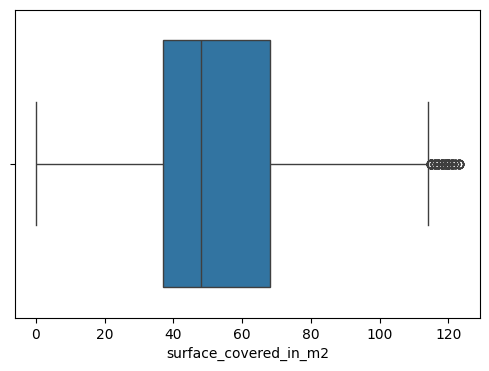

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(x="surface_covered_in_m2", data = df);

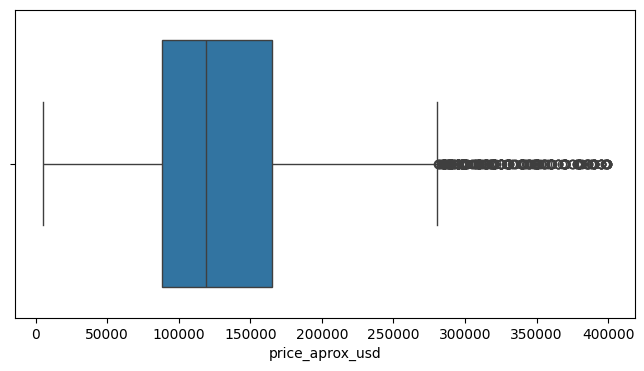

In [14]:
plt.figure(figsize=(8,4))
sns.boxplot(x="price_aprox_usd", data = df);

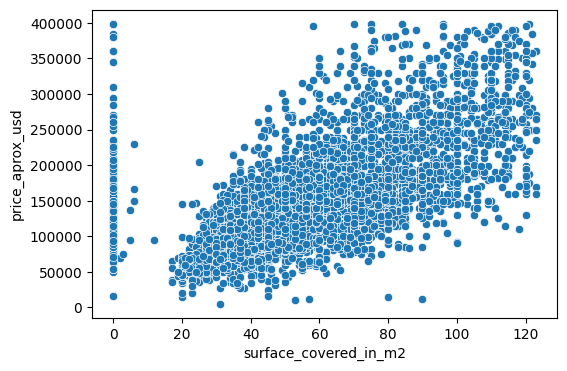

In [15]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.scatterplot(x="surface_covered_in_m2", y="price_aprox_usd", data = df);

### Split

feature matrix named `X_train`, which you'll use to train your model.

In [16]:
features = ["surface_covered_in_m2"]
X_train = df[features]
print(X_train.shape)
X_train.head()

(7341, 1)


,surface_covered_in_m2
0,110.0
4,70.0
9,42.0
11,28.0
20,22.0


target vector

In [17]:
target = "price_aprox_usd"
y_train = df[target]
print(y_train.shape)
y_train.head()

(7341,)


0     180000.0
4     129000.0
9      87000.0
11     60000.0
20     69000.0
Name: price_aprox_usd, dtype: float64

# Build Model

## Baseline

Knowing about the "dumb" model or naïve or baseline model, but it's always a model makes only one prediction — it's mean.

In [18]:
y_mean = y_train.mean()
y_mean

np.float64(136523.2577741452)

In [19]:
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:5]

[np.float64(136523.2577741452),
 np.float64(136523.2577741452),
 np.float64(136523.2577741452),
 np.float64(136523.2577741452),
 np.float64(136523.2577741452)]

C:\Users\admin1\AppData\Local\Temp\ipykernel_38976\2441453366.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


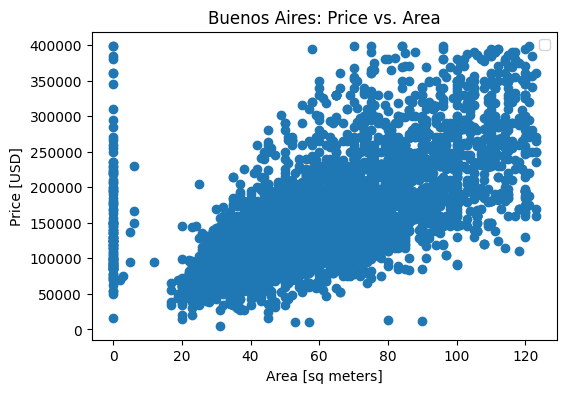

In [20]:
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

In [22]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 136523.26
Baseline MAE: 51546.38


## Iterate

The next step in building a model is iterating. This involves building a model, training it, evaluating it, and then repeating the process until you're happy with the model's performance. Even though the model we're building is linear, the iteration process rarely follows a straight line.

### **Linear Regression**

Instantiate --> Train --> Predict

In [23]:
model = LinearRegression()

In [24]:
model.fit(X_train, y_train)

LinearRegression()

In [25]:
check_is_fitted(model)

In [26]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([249269.30564107, 168540.62916138, 112030.5556256 ,  83775.51885771,
        71666.21738576])

In [27]:
mean_absolute_error(y_train, y_pred_training)

33494.98695319883

`mean_absolute_error` should be `less` as possible for `more accuracy`

# Communicate Results

Once your model is built and tested, presenting to simple linear model to a technical audience done by an equation. Our model has determined for the intercept and and coefficient. 

<font size="+3"><strong> y = m x + c </strong></font>

<strong>prediction = slope * coefficient + intercept</strong>

* Extract the intercept from your model

In [28]:
intercept = round(model.intercept_,2)
coefficient = round(model.coef_[0],2)
print(f"apt_price = {coefficient} * surface_covered + {intercept}")

apt_price = 2018.22 * surface_covered + 27265.45


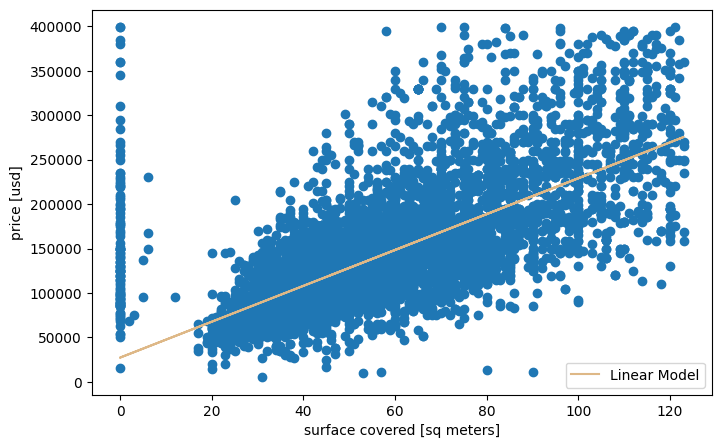

In [29]:
plt.figure(figsize=(8,5))
plt.plot(X_train, model.predict(X_train), color="burlywood", label="Linear Model")
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.legend();

<font size="+2"><strong>Apt_price = 2018.22 * Surface_covered + 27265.45**</strong></font>

# Location vs Price

In [30]:
df[["lat","lon"]] = df["lat-lon"].str.split(",", expand= True).astype(float)
df.drop(columns= ["lat-lon"],inplace= True)

In [31]:
df.head()

,property_type,place_with_parent_names,price_aprox_usd,surface_covered_in_m2,lat,lon
0,apartment,|Argentina|Capital Federal|Villa Crespo|,180000.0,110.0,-34.604783,-58.458681
4,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,70.0,-34.584651,-58.454693
9,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,42.0,-34.638979,-58.500115
11,apartment,|Argentina|Capital Federal|Once|,60000.0,28.0,-34.605006,-58.400116
20,apartment,|Argentina|Capital Federal|San Nicolás|,69000.0,22.0,-34.603898,-58.378617


In [32]:
df.shape

(7341, 6)

### Mapbox Scatter plot

In [33]:
import plotly.express as px
import plotly.graph_objects as go

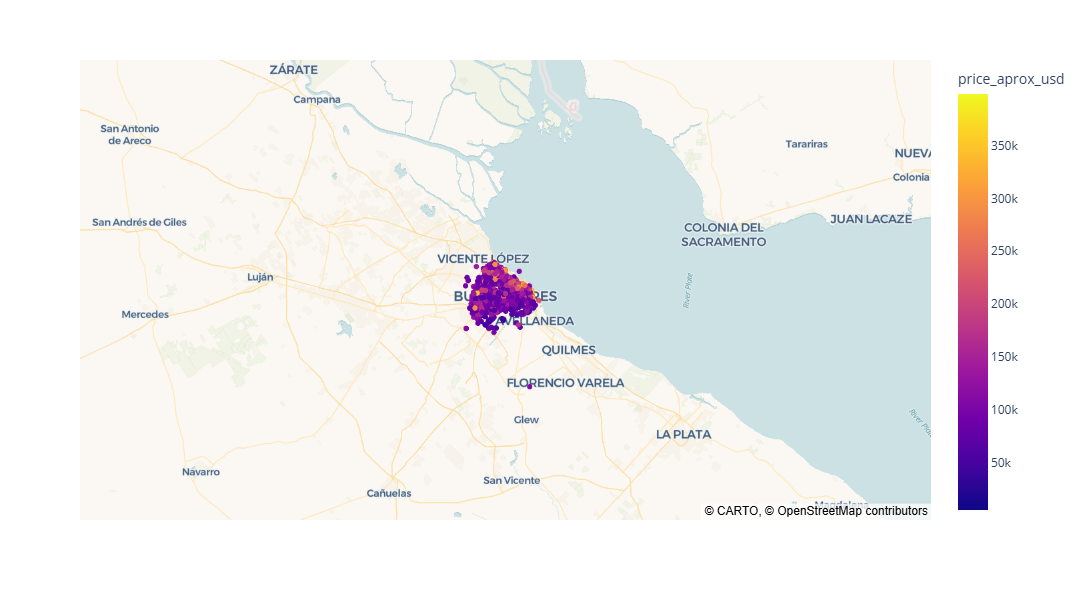

In [34]:
fig = px.scatter_map(
    df,
    lat="lat",
    lon="lon",
    width=800,  # Width of map
    height=600,  # Height of map
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()


### 3D scatter plot of Latitude, Longitude, prices

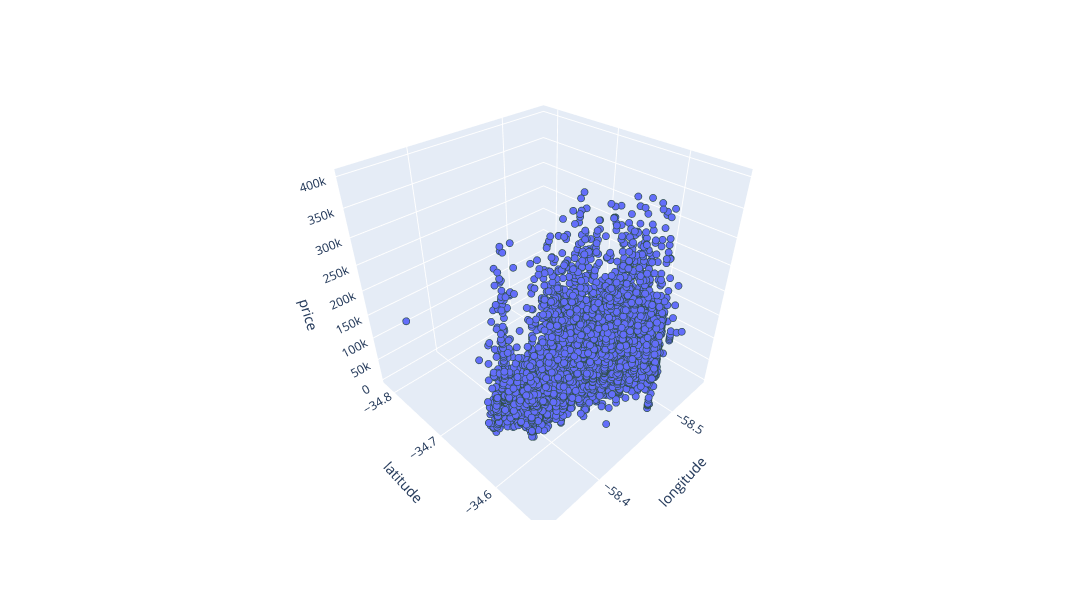

In [35]:
fig= px.scatter_3d(
    df,
    x="lon",
    y="lat",
    z="price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width = 1000,
    height= 600,   
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

### Split

In [36]:
features = ["lon", "lat"]
X_train = df[features]

In [37]:
target = "price_aprox_usd"
y_train = df[target]

## Build Model

### Base Line Model

In [38]:
y_mean = y_train.mean()

In [39]:
y_pred_baseline = [y_mean] * y_train

In [40]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

In [41]:
mae_baseline

18638463390.007927

### Multi-Linear Regression

In [42]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

In [43]:
imputer = SimpleImputer()

In [44]:
imputer.fit(X_train)

SimpleImputer()

In [45]:
imputer.transform(X_train)

array([[-58.45868125, -34.60478342],
       [-58.45469326, -34.5846509 ],
       [-58.500115  , -34.6389789 ],
       ...,
       [-58.4907391 , -34.6522327 ],
       [-58.50018   , -34.648761  ],
       [-58.3873595 , -34.6203841 ]], shape=(7341, 2))

In [46]:
model = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)

In [47]:
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [48]:
check_is_fitted(model["linearregression"])

In [49]:
y_pred_lr = model.predict(X_train)

In [50]:
mae_lr = mean_absolute_error(y_train, y_pred_lr)

In [51]:
mae_lr

49025.71017305777

### Communication Results

<font size="+2"><strong>y = m1x1 + m2x2 + c<strong></font>

In [52]:
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_

In [53]:
print(
    
    f"price = {intercept} + ({coefficients[0]} * longitude) + ({coefficients[1]} * latitude)"
)

price = 38330782.20599266 + (179465.1489054583 * longitude) + (800807.5192029857 * latitude)


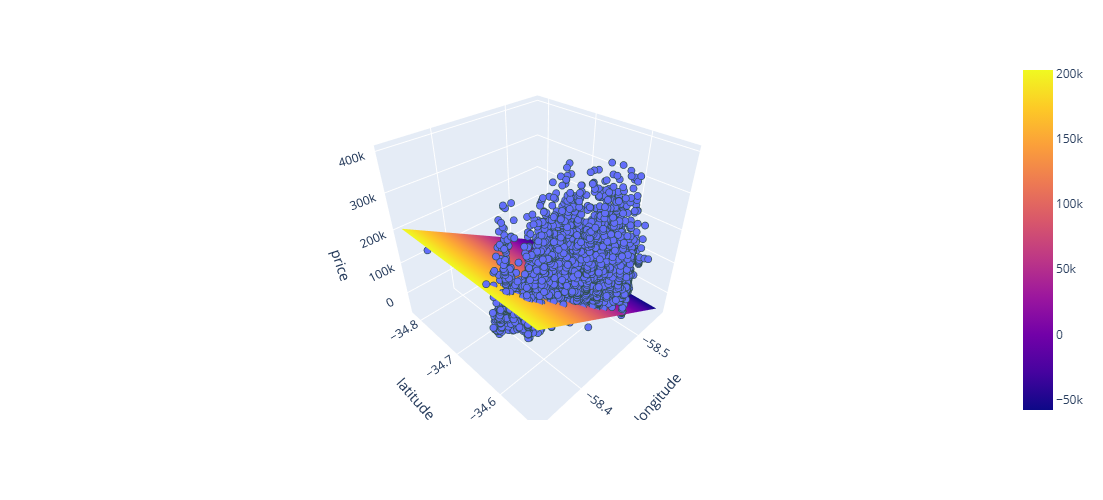

In [54]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x="lon",
    y="lat",
    z="price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Create x and y coordinates for model representation
x_plane = np.linspace(df["lon"].min(), df["lon"].max(), 10)
y_plane = np.linspace(df["lat"].min(), df["lat"].max(), 10)
xx, yy = np.meshgrid(x_plane, y_plane)

# Use model to predict z coordinates
z_plane = model.predict(pd.DataFrame({"lon": x_plane, "lat": y_plane}))
zz = np.tile(z_plane, (10, 1))

# Add plane to figure
fig.add_trace(go.Surface(x=xx, y=yy, z=zz))

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

# Price and Neighborhood

Goals:
* Build model to predict price based on Neighborhood
* Encoding categorical data
* Battle overfitting using regularization

In [55]:
from glob import glob
from category_encoders import OneHotEncoder
from sklearn.linear_model import Ridge 

In [56]:
# glob is used for importing 100's of csv files at once

In [57]:
files = glob("data/buenos-aires-real-estate*.csv")
files

['data\\buenos-aires-real-estate.csv']

In [58]:
df['neighbourhood'] = df['place_with_parent_names'].str.split('|', expand=True)[3]
df.drop(columns=["place_with_parent_names"], inplace= True)

In [59]:
df.head()

,property_type,price_aprox_usd,surface_covered_in_m2,lat,lon,neighbourhood
0,apartment,180000.0,110.0,-34.604783,-58.458681,Villa Crespo
4,apartment,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,apartment,87000.0,42.0,-34.638979,-58.500115,Villa Luro
11,apartment,60000.0,28.0,-34.605006,-58.400116,Once
20,apartment,69000.0,22.0,-34.603898,-58.378617,San Nicolás


**split**

In [60]:
target = "price_aprox_usd"
features = ["neighbourhood"]
y_train = df[target]
X_train = df[features]

**base line model**

In [61]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 136523.2577741452
Baseline MAE: 51546.37955632556


**One hot encoder**

In [62]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(7341, 56)


,neighbourhood_Villa Crespo,neighbourhood_Chacarita,neighbourhood_Villa Luro,neighbourhood_Once,neighbourhood_San Nicolás,neighbourhood_Caballito,neighbourhood_Centro / Microcentro,neighbourhood_Constitución,neighbourhood_Almagro,neighbourhood_Palermo,...,neighbourhood_Boca,neighbourhood_Puerto Madero,neighbourhood_Agronomía,neighbourhood_Monte Castro,neighbourhood_Tribunales,neighbourhood_Villa Santa Rita,neighbourhood_Velez Sarsfield,neighbourhood_Pompeya,neighbourhood_Villa Soldati,neighbourhood_Villa Real
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighbourhood'], use_cat_names=True)),
                ('linearregression', LinearRegression())])

In [64]:
check_is_fitted(model[-1])

In [65]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 46183.92


In [66]:
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])

coefficients len: 56
[ 7.42656848e+03 -7.00436310e+03  7.23024258e+00 -3.69712669e+03
 -1.76596852e+04]


In [67]:
feature_names = model.named_steps["onehotencoder"].get_feature_names_out()
print("features len:", len(feature_names))
print(feature_names[:5])

features len: 56
['neighbourhood_Villa Crespo' 'neighbourhood_Chacarita'
 'neighbourhood_Villa Luro' 'neighbourhood_Once'
 'neighbourhood_San Nicolás']


In [68]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighbourhood_Villa Crespo     7426.568478
neighbourhood_Chacarita       -7004.363105
neighbourhood_Villa Luro          7.230243
neighbourhood_Once            -3697.126692
neighbourhood_San Nicolás    -17659.685220
dtype: float64

In [69]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 119924.3
+ (7426.57 * neighbourhood_Villa Crespo)
+ (-7004.36 * neighbourhood_Chacarita)
+ (7.23 * neighbourhood_Villa Luro)
+ (-3697.13 * neighbourhood_Once)
+ (-17659.69 * neighbourhood_San Nicolás)
+ (15713.16 * neighbourhood_Caballito)
+ (-11565.19 * neighbourhood_Centro / Microcentro)
+ (-48625.18 * neighbourhood_Constitución)
+ (3080.59 * neighbourhood_Almagro)
+ (45522.6 * neighbourhood_Palermo)
+ (-3776.82 * neighbourhood_Flores)
+ (53421.47 * neighbourhood_Belgrano)
+ (-16974.3 * neighbourhood_Liniers)
+ (-12937.27 * neighbourhood_San Cristobal)
+ (-12176.1 * neighbourhood_Congreso)
+ (20897.76 * neighbourhood_Saavedra)
+ (-10733.34 * neighbourhood_Balvanera)
+ (-34747.83 * neighbourhood_Parque Avellaneda)
+ (77172.97 * neighbourhood_Recoleta)
+ (1841.21 * neighbourhood_San Telmo)
+ (46676.72 * neighbourhood_Nuñez)
+ (56047.27 * neighbourhood_Barrio Norte)
+ (-9013.08 * neighbourhood_Parque Centenario)
+ (-3565.68 * neighbourhood_Abasto)
+ (-11474.24 * neighbourhood_Pa

In [70]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighbourhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [71]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 46189.9


In [72]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])

coefficients len: 56
[  6748.89295506  -7510.09911696   -649.46225039  -4312.44866022
 -18044.27736348]


In [73]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 120586.5
+ (7426.57 * neighbourhood_Villa Crespo)
+ (-7004.36 * neighbourhood_Chacarita)
+ (7.23 * neighbourhood_Villa Luro)
+ (-3697.13 * neighbourhood_Once)
+ (-17659.69 * neighbourhood_San Nicolás)
+ (15713.16 * neighbourhood_Caballito)
+ (-11565.19 * neighbourhood_Centro / Microcentro)
+ (-48625.18 * neighbourhood_Constitución)
+ (3080.59 * neighbourhood_Almagro)
+ (45522.6 * neighbourhood_Palermo)
+ (-3776.82 * neighbourhood_Flores)
+ (53421.47 * neighbourhood_Belgrano)
+ (-16974.3 * neighbourhood_Liniers)
+ (-12937.27 * neighbourhood_San Cristobal)
+ (-12176.1 * neighbourhood_Congreso)
+ (20897.76 * neighbourhood_Saavedra)
+ (-10733.34 * neighbourhood_Balvanera)
+ (-34747.83 * neighbourhood_Parque Avellaneda)
+ (77172.97 * neighbourhood_Recoleta)
+ (1841.21 * neighbourhood_San Telmo)
+ (46676.72 * neighbourhood_Nuñez)
+ (56047.27 * neighbourhood_Barrio Norte)
+ (-9013.08 * neighbourhood_Parque Centenario)
+ (-3565.68 * neighbourhood_Abasto)
+ (-11474.24 * neighbourhood_Pa

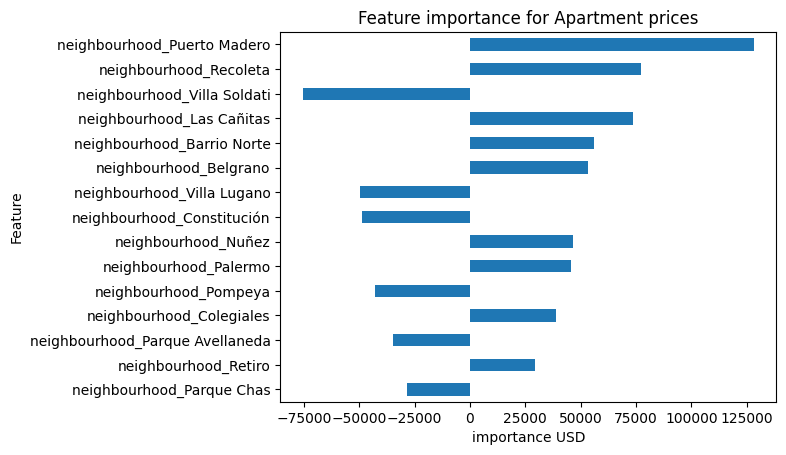

In [74]:
feat_imp.sort_values(key= abs).tail(15).plot(kind="barh")
plt.xlabel("importance USD")
plt.ylabel("Feature")
plt.title("Feature importance for Apartment prices");

Looking at this bar chart, we can see that the poshest neighborhoods in Buenos Aires like Puerto Madero and Recoleta increase the predicted price of an apartment, while more working-class neighborhoods like Villa Soldati and Villa Lugano decrease the predicted price. 

<font size="+3"><strong>2.4. Predicting Price with Size, Location, and Neighborhood</strong></font>

In [75]:
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

In [76]:
df.head()

,property_type,price_aprox_usd,surface_covered_in_m2,lat,lon,neighbourhood
0,apartment,180000.0,110.0,-34.604783,-58.458681,Villa Crespo
4,apartment,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,apartment,87000.0,42.0,-34.638979,-58.500115,Villa Luro
11,apartment,60000.0,28.0,-34.605006,-58.400116,Once
20,apartment,69000.0,22.0,-34.603898,-58.378617,San Nicolás


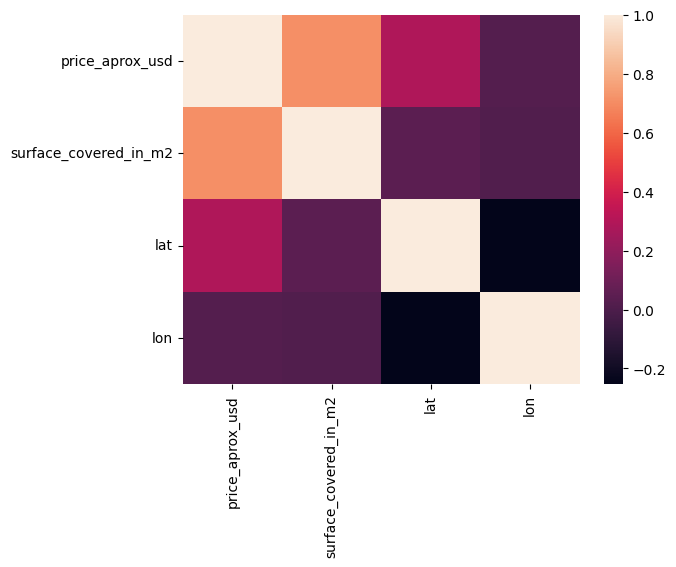

In [77]:
corr = df.select_dtypes('number').corr()
sns.heatmap(corr);

In [78]:
target = "price_aprox_usd"
features = ['surface_covered_in_m2','lat','lon','neighbourhood']
y_train = df[target]
X_train = df[features]

In [79]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 136523.2577741452
Baseline MAE: 51546.37955632556


In [80]:
model = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(), 
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['neighbourhood'])),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [81]:
check_is_fitted(model)

In [82]:
y_pred_training = model.predict(X_train)

print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 27232.515102728266


In [83]:
def make_prediction(area, lat, lon, neighbourhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighbourhood": neighbourhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [84]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighbourhood= Dropdown(options=sorted(X_train["neighbourhood"].unique())),
);

interactive(children=(IntSlider(value=54, description='area', max=123), FloatSlider(value=-34.59886816665702, …